## Import files

In [ ]:
# Relevant imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression
import datetime
import pandas_datareader.data as pdr
import datetime as dt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import pandas as pd
# To extract and parse fundamental data from finviz website
import requests
from bs4 import BeautifulSoup as bs
# For parsing financial statements data from financialmodelingprep api
from urllib.request import urlopen
import json
import seaborn as sns
import os
from io import StringIO


# Settings to produce readable plots in a Jupyter notebook
plt.style.use('fivethirtyeight')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]

# Used to fetch JSON data from a URL and parse it into a Python object.
def get_jsonparsed_data(url):
    response = urlopen(url)
    data = response.read().decode("utf-8")
    return json.loads(data)

# Financialmodelingprep api url
base_url = "https://financialmodelingprep.com/api/v3/"

# Financialmodelingprep api key, get yourself a free version on their website: https://site.financialmodelingprep.com/
apiKey = "0c2c37becc8572a864aeeea67ce96739"

# List of S&P 500 tickers
tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol']

# Add SPY ticker to the list which is used as a proxy for the market index.
tickers = tickers.append(pd.Series(['SPY']), ignore_index=True)


## Get financial data from financialmodelingprep.com

In [ ]:
all_statements = []
# Den kan maks køre 25 tickers af gangen
tickers_of_interest = tickers.iloc[483:502].tolist() + [tickers.iloc[503]]
for ticker in tickers_of_interest:
    if ticker != 'SPY':
        try:
            #Income Statement

            income_statement = pd.DataFrame(get_jsonparsed_data(base_url+'income-statement/' + ticker + '?apikey=' + apiKey))
            income_statement['date'] = pd.to_datetime(income_statement['date'])
            income_statement['date'] = income_statement['date'].dt.year
            income_statement = income_statement.set_index('date')
            income_statement = income_statement[~income_statement.index.duplicated(keep='first')]
            income_statement = income_statement.apply(pd.to_numeric, errors='coerce')
            income_statement.columns = income_statement.columns.str.replace('symbol', 'ticker')
            income_statement = income_statement[income_statement.index <= 2018]
            income_statement = income_statement[income_statement.index >= 2013]
            income_statement['industry'] = get_jsonparsed_data(base_url+'profile/' + ticker + '?apikey=' + apiKey)[0]['industry']
            income_statement['ticker'] = income_statement['ticker'].fillna(ticker)
  

            #Cash Flow
            cash_flow_statement = pd.DataFrame(get_jsonparsed_data(base_url+'cash-flow-statement/' + ticker + '?apikey=' + apiKey))
            cash_flow_statement['date'] = pd.to_datetime(cash_flow_statement['date'])
            cash_flow_statement['date'] = cash_flow_statement['date'].dt.year
            cash_flow_statement = cash_flow_statement.set_index('date')
            cash_flow_statement = cash_flow_statement[~cash_flow_statement.index.duplicated(keep='first')]
            cash_flow_statement = cash_flow_statement.apply(pd.to_numeric, errors='coerce')
            cash_flow_statement = cash_flow_statement[cash_flow_statement.index <= 2018]
            cash_flow_statement = cash_flow_statement[cash_flow_statement.index >= 2013]


            #Balance
            balance_statement = pd.DataFrame(get_jsonparsed_data(base_url+'balance-sheet-statement/' + ticker + '?apikey=' + apiKey))
            balance_statement['date'] = pd.to_datetime(balance_statement['date'])
            balance_statement['date'] = balance_statement['date'].dt.year
            balance_statement = balance_statement.set_index('date')
            balance_statement = balance_statement[~balance_statement.index.duplicated(keep='first')]
            balance_statement = balance_statement.iloc[::-1].apply(pd.to_numeric, errors='coerce')
            balance_statement = balance_statement[balance_statement.index <= 2018]
            balance_statement = balance_statement[balance_statement.index >= 2013]

            #Shareprice
            shareprice = pd.DataFrame(get_jsonparsed_data(base_url+ 'financial-ratios/' + ticker + '?apikey=' + apiKey))
            shareprice = shareprice["ratios"].apply(pd.Series)
            shareprice['date'] = pd.to_datetime(shareprice['date'])
            shareprice['date'] = shareprice['date'].dt.year
            shareprice = shareprice.set_index('date')
            shareprice = shareprice[~shareprice.index.duplicated(keep='first')]
            shareprice = shareprice["investmentValuationRatios"].apply(pd.Series)
            shareprice = shareprice[shareprice.index <= 2018]
            shareprice = shareprice[shareprice.index >= 2013]


            #dcf
            dcf = pd.DataFrame(get_jsonparsed_data(base_url+ 'historical-discounted-cash-flow-statement/' + ticker + '?apikey=' + apiKey))
            dcf = pd.DataFrame(get_jsonparsed_data(base_url+ 'historical-discounted-cash-flow-statement/' + ticker + '?apikey=' + apiKey))
            dcf['date'] = pd.to_datetime(dcf['date'])
            dcf['date'] = dcf['date'].dt.year
            dcf = dcf.set_index('date')
            dcf = dcf[~dcf.index.duplicated(keep='first')]
            dcf = dcf[dcf.index == 2018]
            dcf['ticker'] =dcf['symbol']
            dcf = dcf.drop(['symbol'], axis=1)
            

            market_cap = pd.DataFrame(get_jsonparsed_data(base_url+ 'historical-market-capitalization/' + ticker + '?' 'limit=10000&' 'apikey=' + apiKey))
            market_cap['date'] = pd.to_datetime(market_cap['date'])
            market_cap['date'] = market_cap['date'].dt.year
            market_cap = market_cap.set_index('date')
            market_cap = market_cap[~market_cap.index.duplicated(keep='first')]
            market_cap = market_cap[market_cap.index == 2018]
            market_cap['ticker'] = ticker
            market_cap = market_cap.drop(['symbol'], axis=1)
            
            tc = pd.DataFrame(get_jsonparsed_data(base_url+ 'ratios/' + ticker + '?apikey=' + apiKey))
            tc['date'] = pd.to_datetime(tc['date'])
            tc['date'] = tc['date'].dt.year
            tc = tc.set_index('date')
            tc = tc[~tc.index.duplicated(keep='first')]
            tc = tc[tc.index == 2018]
            tc = tc["effectiveTaxRate"].apply(pd.Series)
            tc = tc.rename(columns={0: 'eff_tax_rate'})
            tc['ticker'] = ticker




            #concatenate the dataframes balance_statement, cash_flow_statement, income_statement
            all_statement = pd.concat([income_statement, balance_statement, cash_flow_statement, shareprice, dcf, market_cap, tc], axis=1)

            #Liquidity
            #all_statement['current_ratio'] = balance_statement['totalCurrentAssets'] / balance_statement['totalCurrentLiabilities']
            #all_statement['quick_ratio'] = (balance_statement['totalCurrentAssets'] - balance_statement['inventory']) / balance_statement['totalCurrentLiabilities']
            #all_statement['cash_ratio'] = balance_statement['cashAndCashEquivalents'] / balance_statement['totalCurrentLiabilities']
            #all_statement['operating_cash_flow_ratio'] = cash_flow_statement['operatingCashFlow'] / balance_statement['totalCurrentLiabilities']
            all_statement['equity_ratio'] = balance_statement['totalStockholdersEquity'] / balance_statement['totalAssets']

            #Leverage
            all_statement['debt_to_equity'] = balance_statement['totalLiabilities'] / balance_statement['totalStockholdersEquity']
            all_statement['debt_to_assets'] = balance_statement['totalLiabilities'] / balance_statement['totalAssets']
            all_statement['interest_coverage'] = (income_statement['incomeBeforeTax']-income_statement['interestIncome']) / income_statement['interestExpense']

            #effeciency
            #all_statement['asset_turnover'] = income_statement['revenue'] / balance_statement['totalAssets']
            #all_statement['receivable_turnover'] = income_statement['revenue'] / cash_flow_statement['accountsReceivables']

            #profitability
            all_statement['gross_profit_margin'] = income_statement['grossProfit'] / income_statement['revenue']
            all_statement['operating_margin'] = income_statement['operatingIncome'] / income_statement['revenue']
            all_statement['return_on_equity'] = income_statement['netIncome'] / balance_statement['totalStockholdersEquity'] * 100
            all_statement['return_on_assets'] = income_statement['netIncome'] / balance_statement['totalAssets']

            all_statements.append(all_statement)

        except Exception as e:
            print(ticker, e)


final_df = pd.concat(all_statements)

duplicate_columns = final_df.columns.duplicated()
final_df = final_df.loc[:, ~duplicate_columns]

#Beta %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
stock_price = pd.DataFrame(get_jsonparsed_data(base_url+ 'historical-price-full/' + 'spy' + '?from=2013-01-01&to=2018-12-31&apikey=' + apiKey))
stock_price = stock_price["historical"].apply(pd.Series)
stock_price = stock_price.set_index('date')
stock_price['ticker'] = 'spy'
stock_price = stock_price[['adjClose', 'ticker']]

stock_list_beta = []
for ticker in tickers_of_interest:
    try:
        stock_price = pd.DataFrame(get_jsonparsed_data(base_url+ 'historical-price-full/' + ticker + '?from=2013-01-01&to=2018-12-31&apikey=' + apiKey))
        stock_price = stock_price["historical"].apply(pd.Series)
        stock_price = stock_price.set_index('date')
        stock_price['ticker'] = ticker
        stock_price = stock_price[['adjClose', 'ticker']]
        stock_list_beta.append(stock_price)
        
    except Exception as e:
        print(ticker, e)
stock_pd = pd.concat(stock_list_beta, ignore_index=False)   

stock_pd = stock_pd.pivot(columns='ticker', values='adjClose')

data = stock_pd

log_returns = np.log(data/data.shift())
log_returns.dropna(inplace=True)

beta_list = []
for ticker in tickers_of_interest:
    if ticker != 'SPY':
        try:
            cov = log_returns.cov()
            var = log_returns['SPY'].var()
            beta_ticker = cov.loc[ticker, 'SPY']/var
            beta_spy = cov.loc['SPY']/var
            # create a dataframe for the betas
            beta_df = pd.DataFrame({'ticker': [ticker], 'Beta': [beta_ticker]})
            # create a new column called date for 2018-12-31
            beta_df['date'] = 2018
            beta_df = beta_df.set_index('date')
            beta_list.append(beta_df)
        except Exception as e:
            print(ticker, e)
beta_df = pd.concat(beta_list, ignore_index=False)   
final_df = final_df.merge(beta_df, how='left', left_on=['date', 'ticker'], right_on=['date', 'ticker'] )

#sector %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

#Risk free rate %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
start = datetime.datetime(2013, 12, 31)
end = datetime.datetime(2018, 12, 31)

dates = pd.date_range(start, end, freq='12M')

RF_rates = []

for date in dates:
    Treasury = pdr.DataReader(['TB1YR'], 'fred', date, date + pd.Timedelta(days=365))
    RF_rate = float(Treasury.iloc[-1])
    RF_rates.append(RF_rate/100)

RF_rates = pd.DataFrame(RF_rates, index=dates, columns=['RF_rate'])
RF_rates = RF_rates.sort_index(ascending=False)
RF_rates.index = RF_rates.index.year
final_df['RF_rate'] = RF_rates['RF_rate']

#spy_yearly_return %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
spy_yearly_return = pd.DataFrame(get_jsonparsed_data(base_url+ 'historical-price-full/' + 'SPY' + '?from=1992-01-01&to=2018-12-31&apikey=' + apiKey))
spy_yearly_return = spy_yearly_return["historical"].apply(pd.Series)
spy_yearly_return = spy_yearly_return.set_index('date')
spy_yearly_return['ticker'] = 'SPY'
spy_yearly_return = spy_yearly_return[['adjClose',]]
spy_yearly_return.rename(columns={'adjClose': 'SPY'})
spy_yearly_return = (spy_yearly_return['adjClose'].iloc[0] - spy_yearly_return['adjClose'].iloc[-1])/spy_yearly_return['adjClose'].iloc[-1]

#Cost of debt %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# https://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/ratings.htm 
#https://pages.stern.nyu.edu/~adamodar/New_Home_Page/valquestions/syntrating.htm
def cost_of_debt(interest_coverage):
    try:
        if interest_coverage >8.5:
            return 0.0069 
        elif interest_coverage > 6.5 and interest_coverage <= 8.5:
            return 0.0085
        elif interest_coverage > 5.5 and interest_coverage <= 6.5:
            return 0.0123
        elif interest_coverage > 4.25 and interest_coverage <= 5.5:
            return 0.0142
        elif interest_coverage > 3 and interest_coverage <= 4.25:
            return 0.0162
        elif interest_coverage > 2.5 and interest_coverage <= 3:
            return 0.02
        elif interest_coverage > 2.25 and interest_coverage <= 2.5:
            return 0.0242
        elif interest_coverage > 2 and interest_coverage <= 2.25:
            return 0.0313
        elif interest_coverage > 1.75 and interest_coverage <= 2:
            return 0.0455
        elif interest_coverage > 1.5 and interest_coverage <= 1.75:
            return 0.0526
        elif interest_coverage > 1.25 and interest_coverage <= 1.5:
            return 0.0737
        elif interest_coverage > 0.8 and interest_coverage <= 1.25:
            return 0.1157
        elif interest_coverage > 0.65 and interest_coverage <= 0.8:
            return 0.1578
        elif interest_coverage > 0.2 and interest_coverage <= 0.65:
            return 0.1750
        elif interest_coverage > -100000 and interest_coverage <= 0.2:
            return 0.2
    except Exception as e:
        print(f"An error occurred: {e}")
final_df['cost_of_debt']=final_df['interest_coverage'].apply(cost_of_debt)
final_df['cost_of_debt']=final_df['cost_of_debt']+final_df['RF_rate']

#Cost of equity %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

final_df['cost_of_equity'] = final_df['RF_rate'] + (final_df['Beta'] * (spy_yearly_return - final_df['RF_rate']))

#WACC %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

wacc = (final_df['marketCap']/(final_df['marketCap']+final_df['totalDebt']))*final_df['cost_of_equity'] + (final_df['totalDebt']/(final_df['marketCap']+final_df['totalDebt']))*final_df['cost_of_debt']*(1-final_df['eff_tax_rate'])

# brug total debt som proxt for market value of debt: https://site.financialmodelingprep.com/weighted-average-cost-of-capital
final_df['wacc'] = wacc

#sector %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sector_list = []
for ticker in tickers_of_interest:
    if ticker != 'SPY':
        try:
            sector = pd.DataFrame(get_jsonparsed_data(base_url+ 'profile/' + ticker + '?from=1992-01-01&to=2018-12-31&apikey=' + apiKey))
            sector = sector[['symbol', 'sector']]
            sector['ticker'] = sector['symbol']
            sector = sector.drop('symbol', axis=1)
            sector_list.append(sector)
        except Exception as e:
            print(ticker, e)
sector_df = pd.concat(sector_list, ignore_index=False)   
final_df = final_df.merge(sector_df, how='left', left_on=['ticker'], right_on=['ticker'] )
final_df .index = final_df.index

#DONE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#pd.set_option('display.max_columns', 10)
#final_df [['wacc', 'sector', 'ticker', 'marketCap', 'totalDebt', 'cost_of_equity', 'cost_of_debt', 'eff_tax_rate', 'Beta', 'interest_coverage', 'RF_rate']]
#final_df.to_csv(r'C:\Users\Birk\OneDrive - University of Copenhagen\University\Kandidat\2. semester\Seminar. Anv. Corp Finance DK\seminar\merger23.csv')

## Get stock prices for alle the tickers in the S&P500

In [ ]:
tickers_of_interest = tickers.iloc[401:502].tolist()
profit_difference_list = []
for ticker in tickers_of_interest:
    if ticker != 'SPY':
        try:
            stock_price_2019 = pd.DataFrame(get_jsonparsed_data(base_url+ 'historical-price-full/' + ticker + '?from=2014-01-01&to=2019-12-31&apikey=' + apiKey))
            stock_price_2019 = stock_price_2019["historical"].apply(pd.Series)
            stock_price_2019 = stock_price_2019.set_index('date')
            stock_price_2019['ticker'] = ticker
            stock_price_2019 = stock_price_2019[['adjClose', 'ticker']]
            #subtract the first day from the last day

            df = stock_price_2019
            df['date'] = pd.to_datetime(df.index)
            df['year'] = df['date'].dt.year

            df['profit_difference'] = df.groupby(['ticker', 'year'])['adjClose'].transform(lambda x: x.iloc[0] - x.iloc[-1])
            #set year to index
            df = df.set_index('year')
            df['calendarYear'] = df.index - 1
            # remove date column and year column
            df = df.drop(['date'], axis=1)
            df['actual_year_profit'] = df.index
            df = df.set_index('calendarYear')


            profit_difference_list.append(df)
        except Exception as e:
            print(ticker, e)
profit_difference_df = pd.concat(profit_difference_list, ignore_index=False)   
profit_difference_df.to_csv(r'C:\Users\Birk\OneDrive - University of Copenhagen\University\Kandidat\2. semester\Seminar. Anv. Corp Finance DK\seminar\profit_more_years\profit_difference_df_3.csv')


### Merge all the saved csv files 

In [ ]:
#create a function that append all the csv files in a folder
def append_all_csv_in_folder(folder):
    import os
    import pandas as pd
    all_files = os.listdir(folder)
    li = []
    for filename in all_files:
        df = pd.read_csv(folder + "\\" + filename)
        li.append(df)
    frame = pd.concat(li, ignore_index=True)
    return frame

#call the function
#merger = append_all_csv_in_folder(r'C:\Users\Birk\OneDrive - University of Copenhagen\University\Kandidat\2. semester\Seminar. Anv. Corp Finance DK\seminar\Merger')
#final_profit_loss = append_all_csv_in_folder(r'C:\Users\Birk\OneDrive - University of Copenhagen\University\Kandidat\2. semester\Seminar. Anv. Corp Finance DK\seminar\final_profit_loss')
#profit_difference_month = append_all_csv_in_folder(r'C:\Users\Birk\OneDrive - University of Copenhagen\University\Kandidat\2. semester\Seminar. Anv. Corp Finance DK\seminar\profit_month')
#profit_difference_week = append_all_csv_in_folder(r'C:\Users\Birk\OneDrive - University of Copenhagen\University\Kandidat\2. semester\Seminar. Anv. Corp Finance DK\seminar\profit_week')
profit_difference_more_years = append_all_csv_in_folder(r'C:\Users\Birk\OneDrive - University of Copenhagen\University\Kandidat\2. semester\Seminar. Anv. Corp Finance DK\seminar\profit_more_years')

#merger.to_csv(r'C:\Users\Birk\OneDrive - University of Copenhagen\University\Kandidat\2. semester\Seminar. Anv. Corp Finance DK\seminar\final_merger.csv')
#profit_loss_month.to_csv(r'C:\Users\Birk\OneDrive - University of Copenhagen\University\Kandidat\2. semester\Seminar. Anv. Corp Finance DK\seminar\final_profit_month.csv')
#profit_loss_week.to_csv(r'C:\Users\Birk\OneDrive - University of Copenhagen\University\Kandidat\2. semester\Seminar. Anv. Corp Finance DK\seminar\final_profit_week.csv')
profit_difference_more_years.to_csv(r'C:\Users\Birk\OneDrive - University of Copenhagen\University\Kandidat\2. semester\Seminar. Anv. Corp Finance DK\seminar\profit_more_years.csv')


## Define the datasets from csv files

In [ ]:
final_merger = pd.read_csv(r'C:\Users\Birk\OneDrive - University of Copenhagen\University\Kandidat\2. semester\Seminar. Anv. Corp Finance DK\seminar\final_merger.csv')
final_profit_loss = pd.read_csv(r'C:\Users\Birk\OneDrive - University of Copenhagen\University\Kandidat\2. semester\Seminar. Anv. Corp Finance DK\seminar\final_profit_loss.csv')
final_profit_difference_more_years = pd.read_csv(r'C:\Users\Birk\OneDrive - University of Copenhagen\University\Kandidat\2. semester\Seminar. Anv. Corp Finance DK\seminar\profit_more_years.csv')
#final_profit_month = pd.read_csv(r'C:\Users\Birk\OneDrive - University of Copenhagen\University\Kandidat\2. semester\Seminar. Anv. Corp Finance DK\seminar\final_profit_month.csv')
#final_profit_week= pd.read_csv(r'C:\Users\Birk\OneDrive - University of Copenhagen\University\Kandidat\2. semester\Seminar. Anv. Corp Finance DK\seminar\final_profit_week.csv')

In [ ]:
# in final_merger plot priceEarningsRatio and priceToSalesRatio in a histogram
#final_merger['priceEarningsRatio'].plot.hist(bins=100)
#final_merger['priceToSalesRatio'].plot.hist(bins=100)
#final_merger['priceToBookRatio'].plot.hist(bins=100)

# Transform the data
Removing outliers 

In [ ]:
final_merger = final_merger[final_merger['priceEarningsRatio'] > -300]
final_merger = final_merger[final_merger['priceEarningsRatio'] < 300]

final_merger = final_merger[final_merger['priceToSalesRatio'] > -300]
final_merger = final_merger[final_merger['priceToSalesRatio'] < 300]


final_merger = final_merger[final_merger['priceToBookRatio'] > -300]
final_merger = final_merger[final_merger['priceToBookRatio'] < 300]

#cant remove those outliers since it only keeps the year 2018
#final_merger = final_merger[final_merger['dcf'] > -1]
#final_merger = final_merger[final_merger['dcf'] < 400]


final_profit_difference_more_years = final_profit_difference_more_years[final_profit_difference_more_years['profit_difference'] < 1000]
final_profit_difference_more_years = final_profit_difference_more_years[final_profit_difference_more_years['profit_difference'] > -1000]


final_profit_difference_more_years = final_profit_difference_more_years.drop_duplicates(subset=['ticker','actual_year_profit'], keep='first')

In [ ]:
final_profit_difference_more_years.set_index('calendarYear', inplace=True)
final_profit_loss = final_profit_loss.set_index('date')
#final_merger = final_merger.dropna(subset=['priceEarningsRatio'])

In [ ]:
#plot dcf 
plt.figure(figsize=(20,10))
plt.title('DCF')
plt.xlabel('DCF')
plt.ylabel('Frequency')
plt.hist(final_merger['dcf'], bins=100)
plt.show()
# print ticker with dcf >2500
print(final_merger[final_merger['dcf'] > 2500])

## Define the dataframes to be used for testing

In [ ]:
#drop na for the first column
df_ratio = final_merger[['priceEarningsRatio', 'priceToSalesRatio','priceToBookRatio', 'sector','calendarYear','ticker']]
df_wacc = final_merger[['wacc', 'sector','calendarYear','ticker']]
df_dcf = final_merger[['dcf', 'sector','calendarYear','ticker']]

df_ratio2 = df_ratio.groupby('sector')[['priceEarningsRatio', 'priceToSalesRatio','priceToBookRatio']].mean()
df_ratio = df_ratio.merge(df_ratio2, how='left', left_on=['sector'], right_on=['sector'] )
df_ratio['diff_PE'] = df_ratio['priceEarningsRatio_x'] - df_ratio['priceEarningsRatio_y']
df_ratio['diff_PS'] =df_ratio ['priceToSalesRatio_x'] - df_ratio['priceToSalesRatio_y']
df_ratio['diff_PB'] =df_ratio[ 'priceToBookRatio_x'] -df_ratio[ 'priceToBookRatio_y']

df_ratio = df_ratio.set_index('calendarYear')

#Remember that we have subtracted the index by 1.
profit_more_years_2019 = final_profit_difference_more_years[final_profit_difference_more_years['actual_year_profit'] == 2019]
# keep the first row of each ticker
profit_more_years_2019 = profit_more_years_2019.groupby('ticker', as_index=False).first()

#Remember that we have subtracted the index by 1.
profit_more_years_2018 = final_profit_difference_more_years[final_profit_difference_more_years['actual_year_profit'] == 2018]
# keep the first row of each ticker
profit_more_years_2018 = profit_more_years_2018.groupby('ticker', as_index=False).first()


#merge the profit_more_years_2019 & 2018 with the df_dcf on tickers
df_dcf = df_dcf.merge(profit_more_years_2019[['profit_difference','actual_year_profit', 'ticker']], how='left', left_on=['ticker'], right_on=['ticker'] )
df_dcf = df_dcf.merge(profit_more_years_2018[['adjClose','actual_year_profit', 'ticker']], how='left', left_on=['ticker'], right_on=['ticker'] )

# rename actual_year_profit_y to actual_year_profit_2018 and actual_year_profit_x to actual_year_profit_2019

df_dcf = df_dcf.rename(columns={'actual_year_profit_y': 'actual_year_adjclose_2019', 'actual_year_profit_x': 'actual_year_profit_difference_2019'})


In [ ]:
#merge profit_difference_df with the df_ratio by ticker and year but profit_difference_df year column is called adj_year and keep the index
df_ratio2 = df_ratio.merge(final_profit_difference_more_years, how='left', left_on=['ticker','calendarYear'], right_on=['ticker','calendarYear'] )

In [ ]:
# drop na for the profit_difference column and priceEarningsRatio_x
df_ratio2 = df_ratio2.dropna(subset=['profit_difference'])
df_ratio2 = df_ratio2.dropna(subset=['priceEarningsRatio_x'])
df_ratio2 = df_ratio2.drop_duplicates(subset=['ticker','actual_year_profit'], keep='first')



# drop diff_PE containing values above 5000 and below 0 -500
df_ratio2 = df_ratio2[df_ratio2['diff_PE'] > -300]
df_ratio2 = df_ratio2[df_ratio2['diff_PE'] < 300]

df_ratio2 = df_ratio2[df_ratio2['diff_PS'] > -300]
df_ratio2 = df_ratio2[df_ratio2['diff_PS'] < 300]

df_ratio2 = df_ratio2[df_ratio2['diff_PB'] > -300]
df_ratio2 = df_ratio2[df_ratio2['diff_PB'] < 300]

df_dcf = df_dcf[df_dcf['dcf'] > -1]
df_dcf = df_dcf[df_dcf['dcf'] < 2500]


In [ ]:
df_ratio2

### summary

In [ ]:
table1 = df_ratio2[['priceEarningsRatio_x', 'priceToSalesRatio_x', 'priceToBookRatio_x', 'profit_difference']].describe().round(2).to_latex()
table3 = df_dcf['dcf'].describe().round(2).to_latex()
table4 = df_wacc['wacc'].describe().round(2).to_latex()

merged_table = table1.strip() + "\n\n" + table3.strip() + "\n\n" + table4.strip()

print(merged_table)


## Regression for ratios

In [ ]:
X = df_ratio2[['diff_PE', 'diff_PB','diff_PS']]
y = df_ratio2['profit_difference']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

In [ ]:
# print the model.summary table in latex containing only the coefficients and the p-values and the R-squared and the f-statistic and the prob(f-statistic)
print(model.summary().tables[1].as_latex_tabular())
#list also the f-statistic and the prob(f-statistic)
print(model.summary().tables[0].as_latex_tabular())


In [ ]:
#plot diff_PE vs profit_difference
plt.scatter(df_ratio2['diff_PE'], df_ratio2['profit_difference'])
plt.xlabel('diff_PE')
plt.ylabel('profit_difference')
plt.savefig('Plots/diff_PE_vs_profit_difference.png')
plt.show()



In [ ]:
#plot diff_PE vs profit_difference
plt.scatter(df_ratio2['priceEarningsRatio_x'], df_ratio2['profit_difference'])
plt.xlabel('diff_PE')
plt.ylabel('profit_difference')
plt.show()


## Regression for WACC

In [ ]:
df_wacc = final_merger[['ticker', 'wacc', 'sector', 'calendarYear']].dropna()
df_wacc_2 = df_wacc.groupby('sector')['wacc'].mean()
#merge with df
df_wacc= df_wacc.merge(df_wacc_2, how='left', left_on=['sector'], right_on=['sector'] )
#rename wacc_y to wacc_sector
df_wacc = df_wacc.rename(columns={'wacc_y': 'wacc_sector'})
df_wacc['diff_wacc'] =df_wacc['wacc_x']- df_wacc['wacc_sector']
df_wacc

In [ ]:
#display all rows 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 1000)

In [ ]:
df_wacc_profit = df_wacc.merge(profit_more_years_2019, how='left', left_on=['ticker'], right_on=['ticker'] )

df_wacc_profit = df_wacc_profit.dropna()

In [ ]:
df_wacc_profit

In [ ]:
X = df_wacc_profit['diff_wacc']
y = df_wacc_profit['profit_difference']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()


In [ ]:
print(model.summary().tables[1].as_latex_tabular())

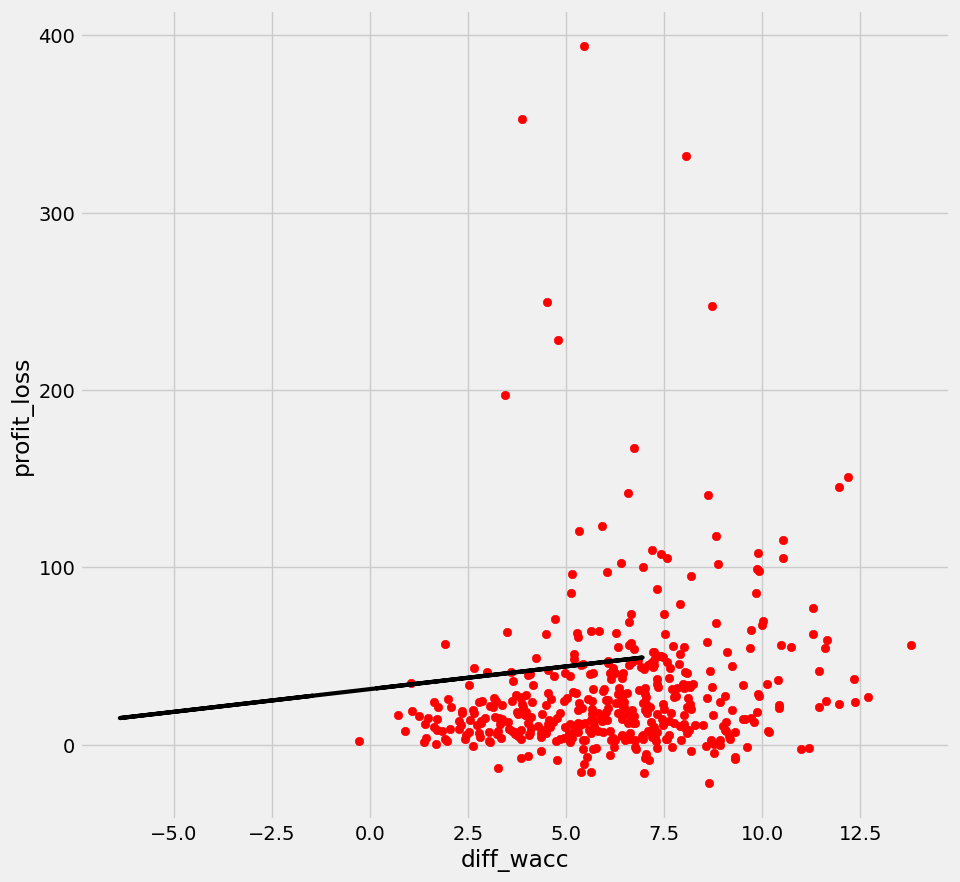

In [16]:
#plot the regression for diff_dcf_price and diff_wacc on profit_difference
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df_wacc_profit['wacc_x'], df_wacc_profit['profit_difference'], color='red')
ax.plot(X['diff_wacc'], predictions, color='black', linewidth=3)
ax.set_xlabel('diff_wacc')
ax.set_ylabel('profit_loss')
plt.savefig('Plots/diff_WACC_vs_profit_difference.png')
plt.show()


## Regression for DCF

In [ ]:
df_dcf

In [17]:

df_dcf['diff_dcf_price'] = df_dcf['dcf']-df_dcf['adjClose']
df_dcf = df_dcf.dropna()

In [18]:
X = df_dcf['diff_dcf_price']
y = df_dcf['profit_difference']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      profit_difference   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     20.93
Date:                Sat, 15 Apr 2023   Prob (F-statistic):           6.94e-06
Time:                        10:42:06   Log-Likelihood:                -1556.2
No. Observations:                 305   AIC:                             3116.
Df Residuals:                     303   BIC:                             3124.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             22.8877      2.723      8.404      0.000      17.529      28.247
diff_dcf_price     0.3218      0.070      4.575      0.000       0.183       0.460
==============================================================================
Omnibus:                      280.083   Durbin-Watson:                   1.843
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7012.294
Skew:                           3.755   Prob(JB):                         0.00
Kurtosis:                      25.257   Cond. No.                         46.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
print(model.summary().tables[1].as_latex_tabular())

\begin{center}
\begin{tabular}{lcccccc}
\toprule
                          & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$> |$t$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{const}            &      22.8877  &        2.723     &     8.404  &         0.000        &       17.529    &       28.247     \\
\textbf{diff\_dcf\_price} &       0.3218  &        0.070     &     4.575  &         0.000        &        0.183    &        0.460     \\
\bottomrule
\end{tabular}
\end{center}


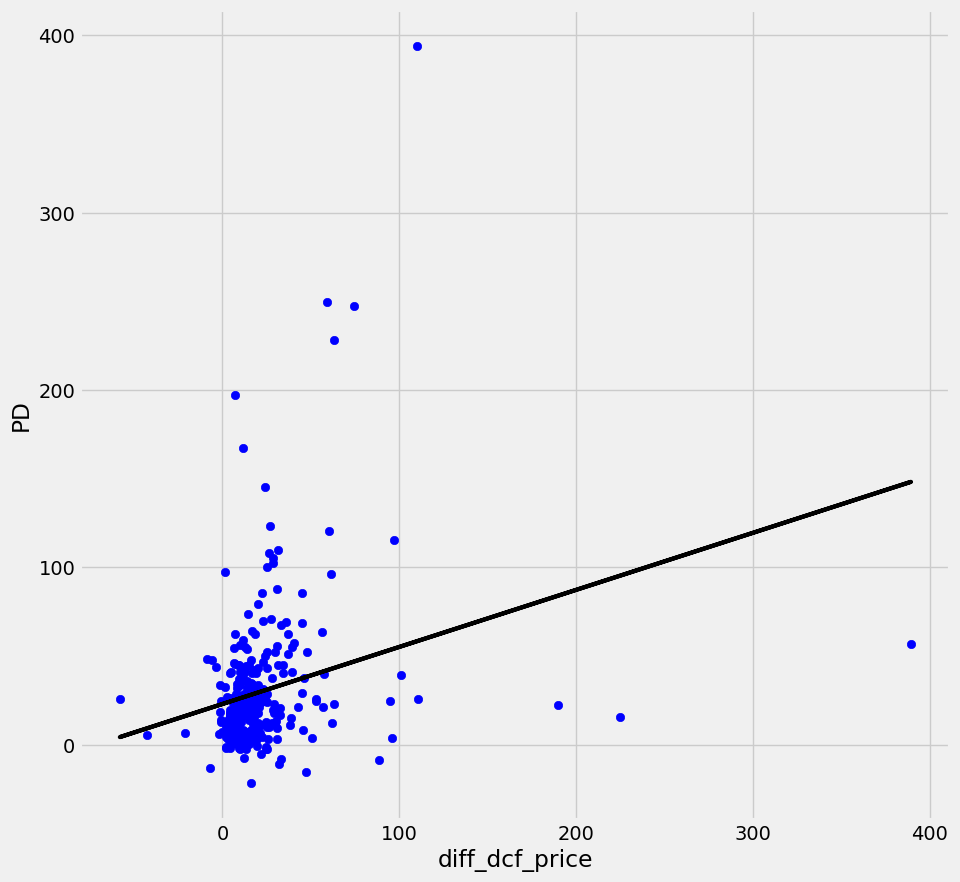

In [22]:
#plot the regression for diff_dcf_price and diff_wacc on profit_difference
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df_dcf['diff_dcf_price'], df_dcf['profit_difference'], color='blue')

ax.plot(df_dcf['diff_dcf_price'], predictions, color='black', linewidth=3)

ax.set_xlabel('diff_dcf_price')
ax.set_ylabel('PD')
plt.savefig('Plots/diff_DCF_vs_profit_difference.png')
plt.show()


## Prediction for ratios

In [24]:
#create a new column in df_ratio2 using an if statement about, if diff_PE is positive and class_profit_difference is 1 assign 1 or if diff_PE is negative and class_profit_difference is 0 assign 1 else 0
df_ratio2['class_profit_difference'] = np.where(df_ratio2['profit_difference'] > 0, 1, 0)
df_ratio2['correct_pred_diff_PE'] = np.where((df_ratio2['diff_PE'] > 0) & (df_ratio2['class_profit_difference'] == 1), 1, np.where((df_ratio2['diff_PE'] < 0) & (df_ratio2['class_profit_difference'] == 0), 1, 0))
df_ratio2['correct_pred_diff_PS'] = np.where((df_ratio2['diff_PS'] > 0) & (df_ratio2['class_profit_difference'] == 1), 1, np.where((df_ratio2['diff_PS'] < 0) & (df_ratio2['class_profit_difference'] == 0), 1, 0))
df_ratio2['correct_pred_diff_PB'] = np.where((df_ratio2['diff_PB'] > 0) & (df_ratio2['class_profit_difference'] == 1), 1, np.where((df_ratio2['diff_PB'] < 0) & (df_ratio2['class_profit_difference'] == 0), 1, 0))


In [25]:
#df_ratio2
#counter number of 1s in correct_pred_diff_PE and correct_pred_diff_PS and correct_pred_diff_PB

#Show the percentage of correct predictions

#show them all in one table
#pd.concat([df_ratio2['correct_pred_diff_PE'].value_counts(normalize=True)*100, df_ratio2['correct_pred_diff_PS'].value_counts(normalize=True)*100, df_ratio2['correct_pred_diff_PB'].value_counts(normalize=True)*100], axis=1)

#inclue the correct_pred_diff_ROE
pd.concat([df_ratio2['correct_pred_diff_PE'].value_counts(normalize=True)*100, df_ratio2['correct_pred_diff_PS'].value_counts(normalize=True)*100, df_ratio2['correct_pred_diff_PB'].value_counts(normalize=True)*100], axis=1)

,correct_pred_diff_PE,correct_pred_diff_PS,correct_pred_diff_PB
0,52.020602,57.92393,55.348653
1,47.979398,42.07607,44.651347


In [28]:
#print latex table and round to 2 decimals
print(pd.concat([df_ratio2['correct_pred_diff_PE'].value_counts(normalize=True)*100, df_ratio2['correct_pred_diff_PS'].value_counts(normalize=True)*100, df_ratio2['correct_pred_diff_PB'].value_counts(normalize=True)*100], axis=1).round(3).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  correct\_pred\_diff\_PE &  correct\_pred\_diff\_PS &  correct\_pred\_diff\_PB \\
\midrule
0 &                52.021 &                57.924 &                55.349 \\
1 &                47.979 &                42.076 &                44.651 \\
\bottomrule
\end{tabular}



C:\Users\Birk\AppData\Local\Temp\ipykernel_24208\2728055995.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat([df_ratio2['correct_pred_diff_PE'].value_counts(normalize=True)*100, df_ratio2['correct_pred_diff_PS'].value_counts(normalize=True)*100, df_ratio2['correct_pred_diff_PB'].value_counts(normalize=True)*100], axis=1).round(3).to_latex())


## Prediction for WACC

In [34]:
#create a new column in df_ratio2 using an if statement about, if diff_PE is positive and class_profit_difference is 1 assign 1 or if diff_PE is negative and class_profit_difference is 0 assign 1 else 0
df_wacc_profit['class_profit_difference'] = np.where(df_wacc_profit['profit_difference'] > 0, 1, 0)
df_wacc_profit['correct_wacc'] = np.where((df_wacc_profit['diff_wacc'] > 0) & (df_wacc_profit['class_profit_difference'] == 1), 1, np.where((df_wacc_profit['diff_wacc'] < 0) & (df_wacc_profit['class_profit_difference'] == 0), 1, 0))

pd.concat([df_wacc_profit['correct_wacc'].value_counts(normalize=True)*100], axis=1)


,correct_wacc
0,52.606635
1,47.393365


In [38]:
# print the latex table
print(pd.concat([df_wacc_profit['correct_wacc'].value_counts(normalize=True)*100], axis=1).round(3).to_latex())

\begin{tabular}{lr}
\toprule
{} &  correct\_wacc \\
\midrule
0 &        52.607 \\
1 &        47.393 \\
\bottomrule
\end{tabular}



C:\Users\Birk\AppData\Local\Temp\ipykernel_24208\2046078130.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat([df_wacc_profit['correct_wacc'].value_counts(normalize=True)*100], axis=1).round(3).to_latex())


## Prediction for DCF

In [ ]:
df_dcf

In [30]:
#create a new column in df_ratio2 using an if statement about, if diff_PE is positive and class_profit_difference is 1 assign 1 or if diff_PE is negative and class_profit_difference is 0 assign 1 else 0
df_dcf['class_profit_difference'] = np.where(df_dcf['profit_difference'] > 0, 1, 0)
df_dcf['correct_dcf'] = np.where((df_dcf['diff_dcf_price'] > 0) & (df_dcf['class_profit_difference'] == 1), 1, np.where((df_dcf['diff_dcf_price'] < 0) & (df_dcf['class_profit_difference'] == 0), 1, 0))

pd.concat([df_dcf['correct_dcf'].value_counts(normalize=True)*100], axis=1)


,correct_dcf
1,89.508197
0,10.491803


In [39]:
#print the latex table
print(pd.concat([df_dcf['correct_dcf'].value_counts(normalize=True)*100], axis=1).round(3).to_latex())

\begin{tabular}{lr}
\toprule
{} &  correct\_dcf \\
\midrule
1 &       89.508 \\
0 &       10.492 \\
\bottomrule
\end{tabular}



C:\Users\Birk\AppData\Local\Temp\ipykernel_24208\2244813436.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat([df_dcf['correct_dcf'].value_counts(normalize=True)*100], axis=1).round(3).to_latex())


In [31]:
#show all the rows where profit_loss is negative
df_dcf[df_dcf['profit_difference'] > 0]

,dcf,sector,calendarYear,ticker,profit_difference,actual_year_profit_difference_2019,adjClose,actual_year_adjclose_2019,diff_dcf_price,class_profit_difference,correct_dcf
6,49.34,Industrials,2018.0,AOS,4.671338,2019.0,39.435112,2018.0,9.904888,1,1
12,73.87,Healthcare,2018.0,ABT,17.554299,2019.0,67.535233,2018.0,6.334767,1,1
18,83.99,Healthcare,2018.0,ABBV,3.519654,2019.0,75.223648,2018.0,8.766352,1,1
24,178.25,Technology,2018.0,ACN,68.517334,2019.0,133.013733,2018.0,45.236267,1,1
30,51.85,Communication Services,2018.0,ATVI,12.545692,2019.0,45.405975,2018.0,6.444025,1,1
36,48.26,Consumer Defensive,2018.0,ADM,6.257542,2019.0,36.484108,2018.0,11.775892,1,1
48,139.22,Industrials,2018.0,ADP,40.182808,2019.0,120.109467,2018.0,19.110533,1,1
54,167.02,Consumer Cyclical,2018.0,AAP,2.339661,2019.0,148.277328,2018.0,18.742672,1,1
65,53.02,Financial Services,2018.0,AFL,7.651130,2019.0,41.049713,2018.0,11.970287,1,1
83,70.88,Technology,2018.0,AKAM,27.369999,2019.0,61.080002,2018.0,9.799998,1,1
